In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import matplotlib as mpl
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-06-01T21:51:23.931877+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1029-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib: 3.10.0
polars    : 1.9.0
teeplot   : 1.4.2
seaborn   : 0.13.2

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-06-01-cpp-bench-speed-native"
)
teeplot_subdir


'2025-06-01-cpp-bench-speed-native'

## Prep Data


In [5]:
algo_names = {
    "dstream.circular_algo": "simple ringbuf",
    "control_throwaway_algo": "discard-only",
    "dstream.steady_algo": "dstream steady",
    "dstream_tilted_algo": "dstream tilted",
    "dstream.compressing_algo": "gunther steady",
    "doubling_steady_algo": "doubling steady",
    "doubling_tilted_algo": "doubling tilted",
    "zhao_tilted_algo": "zhao tilted",
    "zhao_tilted_full_algo": "zhao tilted full",
    "zhao_steady_algo": "zhao steady",
}


df = pl.concat(
    [
        pl.read_csv("https://osf.io/r9ajf/download"),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .filter(
        pl.col("algo_name").is_in(
            algo_names.keys(),
        ),
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            algo_names.__getitem__,
            return_dtype=str,
        )
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,str,f64,f64,f64,f64,f64,f64,str,str
"""count""","""4800""","""4800""","""4800""",4800.0,4800.0,4800.0,4800.0,4800.0,4800.0,"""4800""","""4800"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0"""
"""mean""",null,null,null,2339.908333,370000.0,1360.0,4.5,0.007018,30.284759,null,null
"""std""",null,null,null,4219.237788,447036.5015,1620.124327,2.872581,0.070442,206.377474,null,null
"""min""","""control_throwaway_algo""","""bit""","""g++""",12.0,10000.0,64.0,0.0,0.000013,1.2554,"""discard-only""","""bit"""
"""25%""",null,null,null,132.0,10000.0,256.0,2.0,0.000058,1.392557,null,null
"""50%""",null,null,null,516.0,100000.0,1024.0,5.0,0.000249,1.627256,null,null
"""75%""",null,null,null,2052.0,1e6,1024.0,7.0,0.001456,5.586398,null,null
"""max""","""zhao_tilted_full_algo""","""word""","""g++""",20480.0,1e6,4096.0,9.0,1.485777,2642.1651,"""zhao tilted full""","""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,f64,str,str
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,0,0.000031,3.0659,"""discard-only""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,1,0.000013,1.3375,"""discard-only""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,2,0.000013,1.3348,"""discard-only""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,3,0.000013,1.3313,"""discard-only""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,4,0.000013,1.3344,"""discard-only""","""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,f64,str,str
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,5,0.012034,12.034066,"""zhao tilted full""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,6,0.011279,11.278885,"""zhao tilted full""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,7,0.011607,11.606721,"""zhao tilted full""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,8,0.011094,11.093892,"""zhao tilted full""","""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,9,0.011309,11.309335,"""zhao tilted full""","""bit"""


## Plot


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=num-items-ingested+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=num-items-ingested+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=num-items-ingested+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


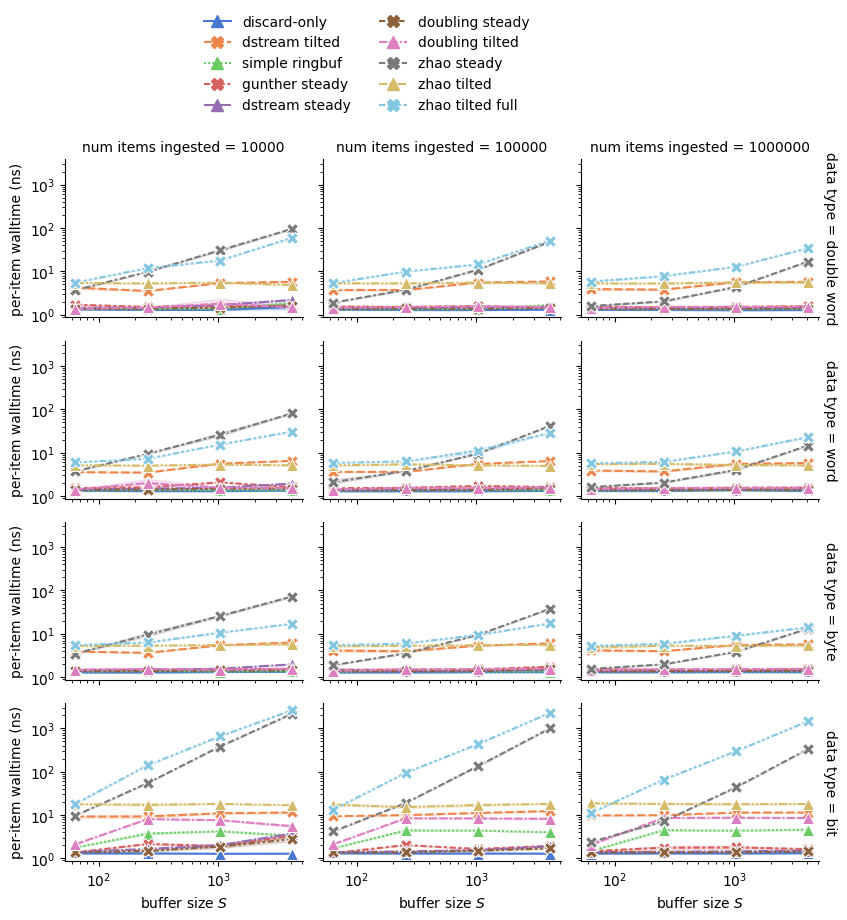

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=num-items-ingested+font.family=serif+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


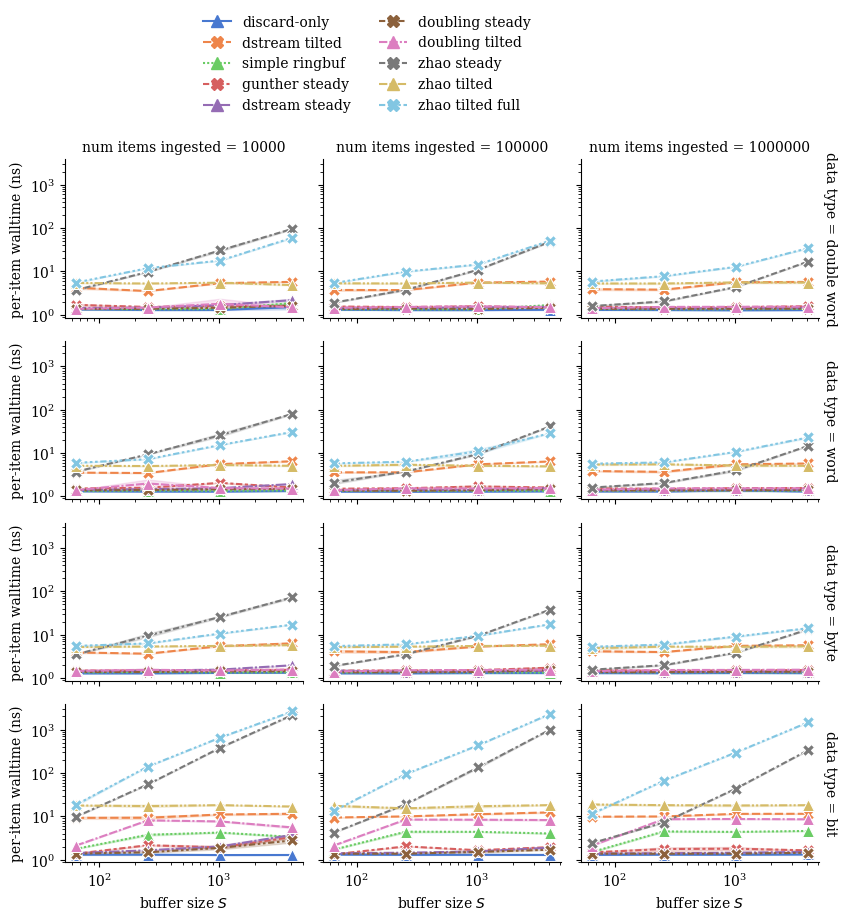

In [6]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.relplot,
            data=df.with_columns(
                pl.col("num_sites").alias("buffer size $S$"),
                pl.col("duration_per_item_ns").alias("per-item walltime (ns)"),
                pl.col("num_items").alias("num items ingested"),
            ),
            x="buffer size $S$",
            y="per-item walltime (ns)",
            col="num items ingested",
            row="data type",
            hue="algorithm",
            style="algorithm",
            palette="muted",
            kind="line",
            aspect=1.5,
            markers=["^", "X"],
            ms=8,
            height=2,
            teeplot_outattrs=rc,
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=True),
        ) as g:
            g.set(xscale="log", yscale="log")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.35, 1),
                ncol=2,
                title=None,
                frameon=False,
            )
            g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


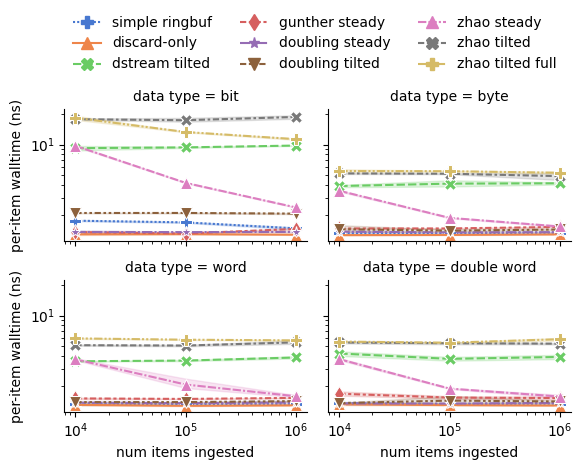

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


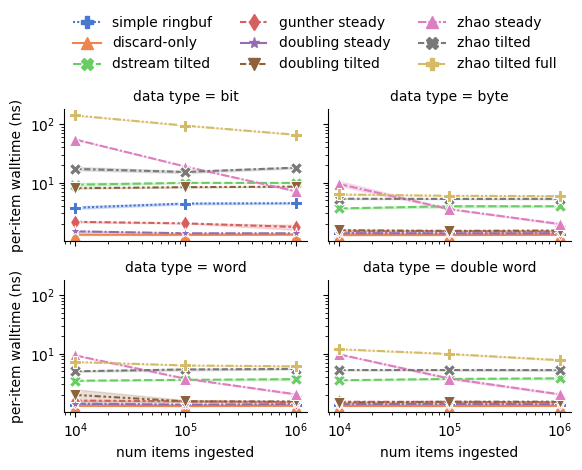

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


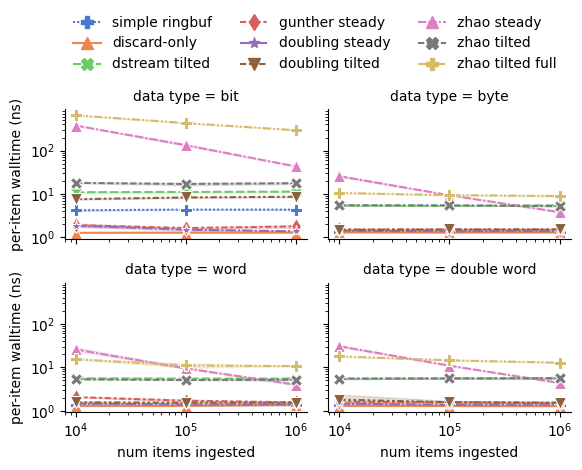

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


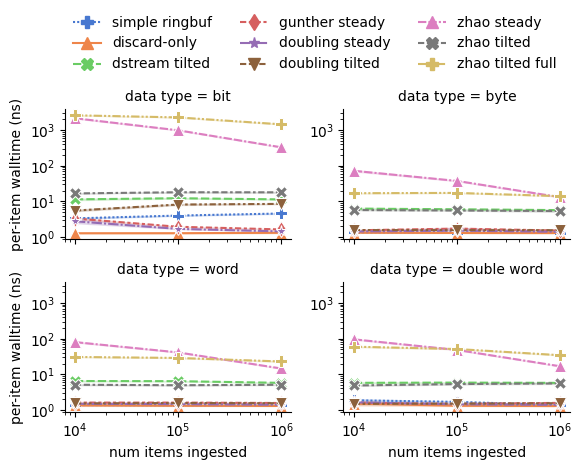

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


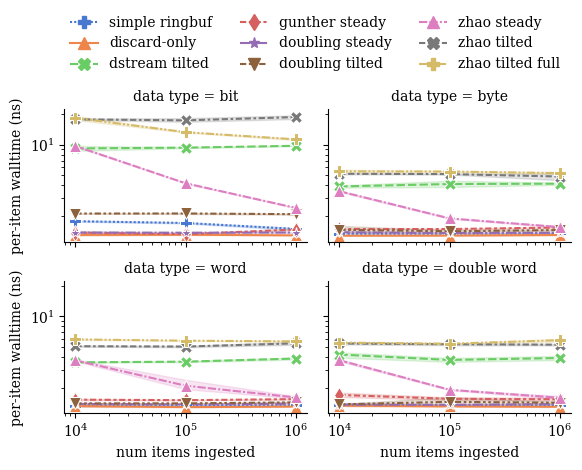

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


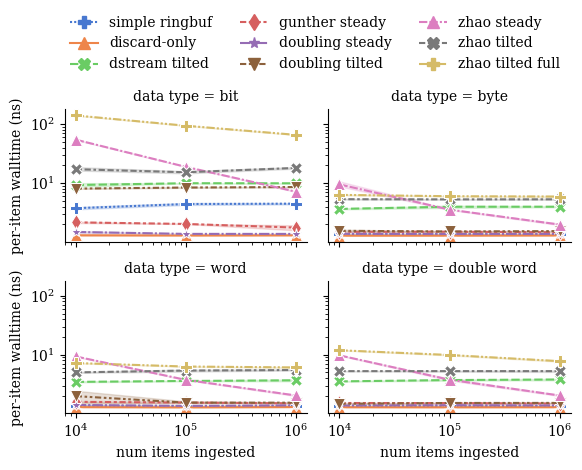

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


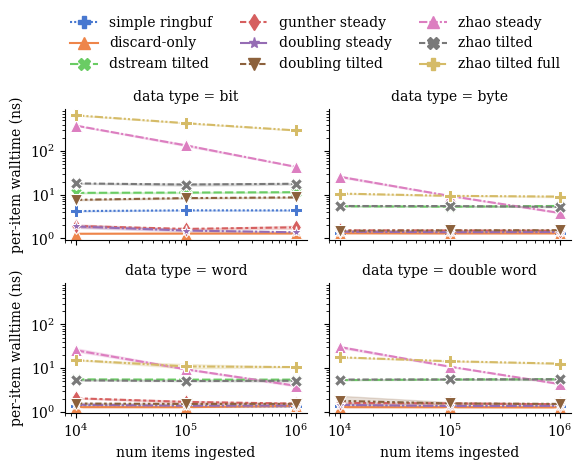

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items-ingested+y=per-item-walltime-ns+ext=.png


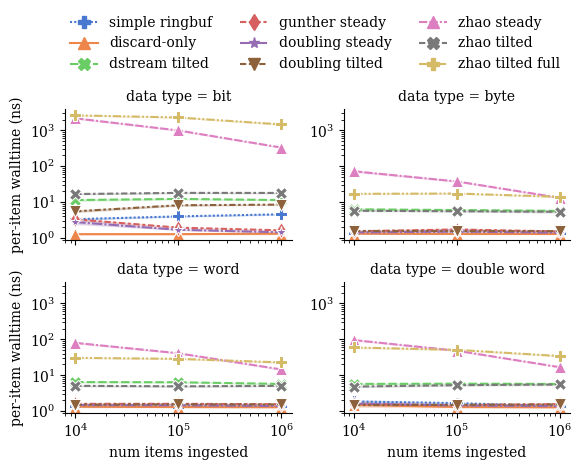

In [7]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        for num_sites in [64, 256, 1024, 4096]:
            with tp.teed(
                sns.relplot,
                data=df.filter(
                    pl.col("algorithm").is_in(
                        [
                            "simple ringbuf",
                            "discard-only",
                            "dstream tilted",
                            "gunther steady",
                            "doubling steady",
                            "doubling tilted",
                            "zhao steady",
                            "zhao tilted",
                            "zhao tilted full",
                        ],
                    ),
                    pl.col("num_sites") == num_sites,
                ).with_columns(
                    pl.col("num_sites").alias("buffer size $S$"),
                    pl.col("duration_per_item_ns").alias("per-item walltime (ns)"),
                    pl.col("num_items").alias("num items ingested"),
                    pl.col("algorithm").str.replace("control: ringbuf", "simple ringbuf").str.replace("control: discard", "discard-only"),
                ),
                x="num items ingested",
                y="per-item walltime (ns)",
                col="data type",
                col_wrap=2,
                col_order=[
                    "bit",
                    "byte",
                    "word",
                    "double word",
                ],
                hue="algorithm",
                hue_order=[
                    "simple ringbuf",
                    "discard-only",
                    "dstream tilted",
                    "gunther steady",
                    "doubling steady",
                    "doubling tilted",
                    "zhao steady",
                    "zhao tilted",
                    "zhao tilted full",
                ],
                style="algorithm",
                palette="muted",
                kind="line",
                aspect=1.5,
                markers=["^", "X", "P", "d", "*", "v"],
                ms=8,
                height=2,
                teeplot_subdir=teeplot_subdir,
                facet_kws=dict(margin_titles=False),
                teeplot_outattrs={
                    "num_sites": num_sites,
                    **rc,
                },
            ) as g:
                g.set(xscale="log", yscale="log")
                sns.move_legend(
                    g,
                    "upper center",
                    bbox_to_anchor=(0.42, 1.18),
                    ncol=3,
                    title=None,
                    frameon=False,
                )
                g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


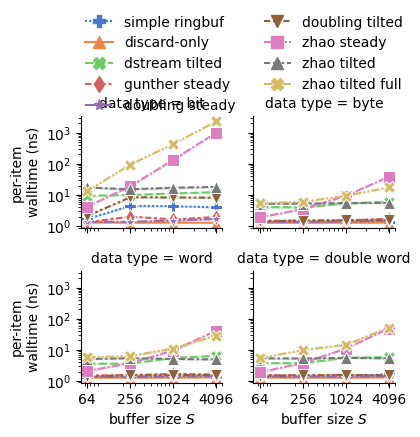

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+ext=.png


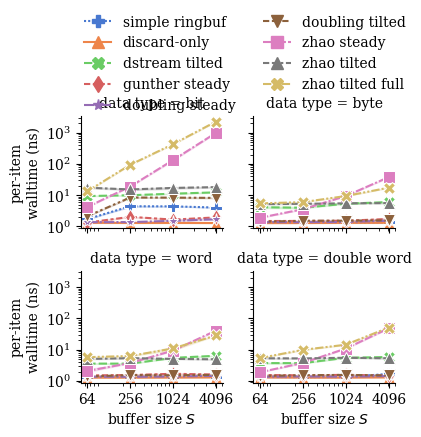

In [8]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.relplot,
            data=df.filter(
                pl.col("algorithm").is_in(
                    [
                        "simple ringbuf",
                        "discard-only",
                        "dstream tilted",
                        "gunther steady",
                        "doubling steady",
                        "doubling tilted",
                        "zhao steady",
                        "zhao tilted",
                        "zhao tilted full",
                    ],
                ),
                pl.col("num_items") == 100_000,
            ).with_columns(
                pl.col("num_sites").alias("buffer size $S$"),
                pl.col("duration_per_item_ns").alias("per-item\nwalltime (ns)"),
                pl.col("num_items").alias("num items ingested"),
                pl.col("algorithm").str.replace("control: ringbuf", "simple ringbuf").str.replace("control: discard", "discard-only"),
            ),
            x="buffer size $S$",
            y="per-item\nwalltime (ns)",
            col="data type",
            col_wrap=2,
            col_order=[
                "bit",
                "byte",
                "word",
                "double word",
            ],
            hue="algorithm",
            hue_order=[
                "simple ringbuf",
                "discard-only",
                "dstream tilted",
                "gunther steady",
                "doubling steady",
                "doubling tilted",
                "zhao steady",
                "zhao tilted",
                "zhao tilted full",
            ],
            style="algorithm",
            palette="muted",
            kind="line",
            aspect=1.2,
            markers=["^", "X", "P", "d", "*", "v", "s"],
            ms=8,
            height=1.8,
            teeplot_outattrs=rc,
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=False),
        ) as g:
            g.set(xscale="log", yscale="log")
            sns.move_legend(
                g,
                "upper center",
                bbox_to_anchor=(0.42, 1.22),
                ncol=2,
                title=None,
                frameon=False,
            )
            for ax in g.axes.flat:
                ax.set_xticks([64, 256, 1024, 4096])
                ax.set_xticklabels(["64", "256", "1024", "4096"])
            g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady=incl+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady=incl+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady=incl+ext=.png


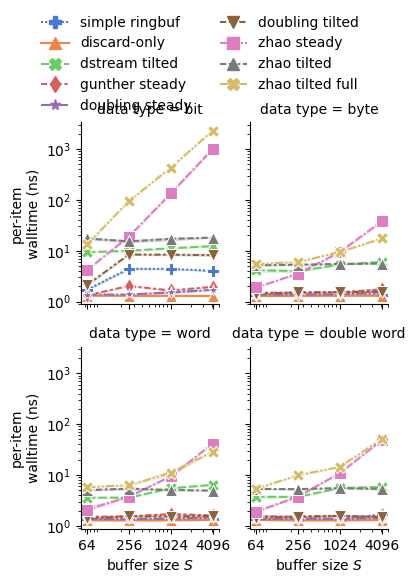

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady=incl+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady=incl+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady=incl+ext=.png


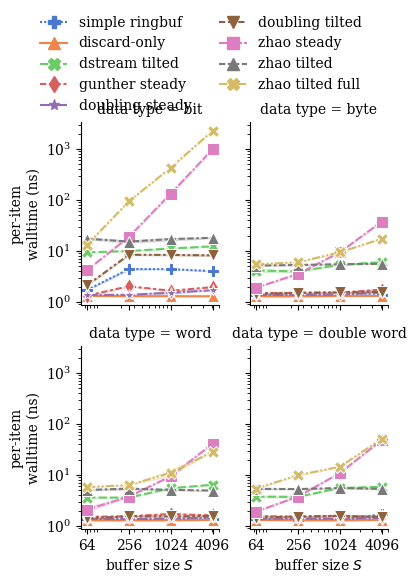

In [9]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.relplot,
            data=df.filter(
                pl.col("algorithm").is_in(
                    [
                        "simple ringbuf",
                        "discard-only",
                        "dstream tilted",
                        "gunther steady",
                        "doubling steady",
                        "doubling tilted",
                        "zhao steady",
                        "zhao tilted",
                        "zhao tilted full",
                    ],
                ),
                pl.col("num_items") == 100_000,
            ).with_columns(
                pl.col("num_sites").alias("buffer size $S$"),
                pl.col("duration_per_item_ns").alias("per-item\nwalltime (ns)"),
                pl.col("num_items").alias("num items ingested"),
                pl.col("algorithm").str.replace("control: ringbuf", "simple ringbuf").str.replace("control: discard", "discard-only"),
            ),
            x="buffer size $S$",
            y="per-item\nwalltime (ns)",
            col="data type",
            col_wrap=2,
            col_order=[
                "bit",
                "byte",
                "word",
                "double word",
            ],
            hue="algorithm",
            hue_order=[
                "simple ringbuf",
                "discard-only",
                "dstream tilted",
                "gunther steady",
                "doubling steady",
                "doubling tilted",
                "zhao steady",
                "zhao tilted",
                "zhao tilted full",
            ],
            style="algorithm",
            palette="muted",
            kind="line",
            aspect=0.85,
            markers=["^", "X", "P", "d", "*", "v", "s"],
            ms=8,
            height=2.5,
            teeplot_outattrs={"zhaosteady": "incl", **rc},
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=False),
        ) as g:
            g.set(xscale="log", yscale="log")
            sns.move_legend(
                g,
                "upper center",
                bbox_to_anchor=(0.35, 1.17),
                ncol=2,
                title=None,
                frameon=False,
            )
            for ax in g.axes.flat:
                ax.set_xticks([64, 256, 1024, 4096])
                ax.set_xticklabels(["64", "256", "1024", "4096"])
            g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady-dstreamsteady=incl+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady-dstreamsteady=incl+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady-dstreamsteady=incl+ext=.png


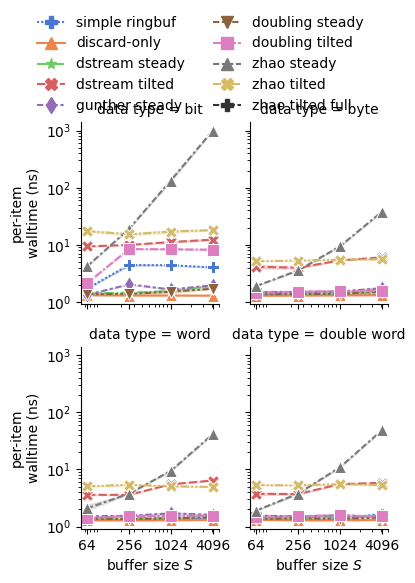

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady-dstreamsteady=incl+ext=.pdf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady-dstreamsteady=incl+ext=.pgf
teeplots/2025-06-01-cpp-bench-speed-native/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=buffer-size-s+y=per-item-walltime-ns+zhaosteady-dstreamsteady=incl+ext=.png


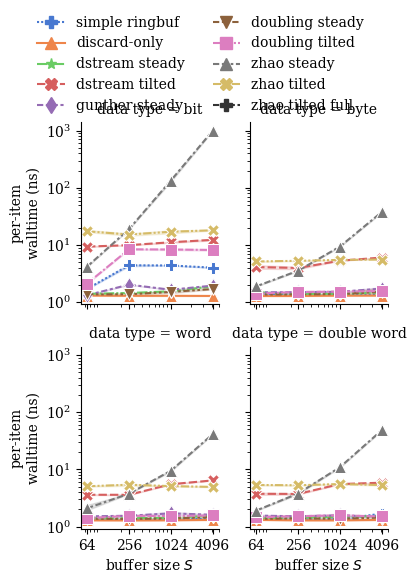

In [10]:
for rc in [{}, {"font.family": "serif"}]:
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.relplot,
            data=df.filter(
                pl.col("algorithm").is_in(
                    [
                        "simple ringbuf",
                        "discard-only",
                        "dstream tilted",
                        "dstream steady",
                        "gunther steady",
                        "doubling steady",
                        "doubling tilted",
                        "zhao steady",
                        "zhao tilted",
                        "zhao tilted full",
                    ],
                ),
                pl.col("num_items") == 100_000,
            ).with_columns(
                pl.col("num_sites").alias("buffer size $S$"),
                pl.col("duration_per_item_ns").alias("per-item\nwalltime (ns)"),
                pl.col("num_items").alias("num items ingested"),
                pl.col("algorithm").str.replace("control: ringbuf", "simple ringbuf").str.replace("control: discard", "discard-only"),
            ),
            x="buffer size $S$",
            y="per-item\nwalltime (ns)",
            col="data type",
            col_wrap=2,
            col_order=[
                "bit",
                "byte",
                "word",
                "double word",
            ],
            hue="algorithm",
            hue_order=[
                "simple ringbuf",
                "discard-only",
                "dstream steady",
                "dstream tilted",
                "gunther steady",
                "doubling steady",
                "doubling tilted",
                "zhao steady",
                "zhao tilted",
            ],
            style="algorithm",
            palette="muted",
            kind="line",
            aspect=0.85,
            markers=["^", "X", "P", "d", "*", "v", "s"],
            ms=8,
            height=2.5,
            teeplot_outattrs={"zhaosteady-dstreamsteady": "incl", **rc},
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=False),
        ) as g:
            g.set(xscale="log", yscale="log")
            sns.move_legend(
                g,
                "upper center",
                bbox_to_anchor=(0.35, 1.17),
                ncol=2,
                title=None,
                frameon=False,
            )
            for ax in g.axes.flat:
                ax.set_xticks([64, 256, 1024, 4096])
                ax.set_xticklabels(["64", "256", "1024", "4096"])
            g.tight_layout()
